In [1]:
# @title Copyright & License (click to expand)
# Copyright 2024 Google LLC
#
# Licensed under the Apache License, Version 2.0 (the "License");
# you may not use this file except in compliance with the License.
# You may obtain a copy of the License at
#
#     https://www.apache.org/licenses/LICENSE-2.0
#
# Unless required by applicable law or agreed to in writing, software
# distributed under the License is distributed on an "AS IS" BASIS,
# WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
# See the License for the specific language governing permissions and
# limitations under the License.

# Supervised Fine Tuning with Gemini 1.5 Pro for Image Captioning

Adapted from: [Gemini 1.5 Pro SFT with Image Data on GitHub](https://github.com/GoogleCloudPlatform/generative-ai/blob/main/gemini/tuning/supervised_finetuning_using_gemini_on_image_data.ipynb)

Author: [Deepak Moonat](https://github.com/dmoonat)

Modified by: [Wan Qi Ang](https://github.com/angwanqi) for 2024 EDB x Google Cloud - Cloud AI Take Off Program

## Overview

**Gemini** is a family of generative AI models developed by Google DeepMind that is designed for multimodal use cases. The Gemini API gives you access to the various Gemini models, such as Gemini 1.5 Pro, Gemini 1.0 Pro and more.

This notebook demonstrates how to fine-tune the Gemini 1.5 Pro Model for Vision task using the Vertex AI Supervised Tuning feature. Supervised Tuning allows you to use your own training data to further refine the base model's capabilities towards your specific tasks.


Supervised Tuning uses labeled examples to tune a model. Each example demonstrates the output you want from your text model during inference.

First, ensure your training data is of high quality, well-labeled, and directly relevant to the target task. This is crucial as low-quality data can adversely affect the performance and introduce bias in the fine-tuned model.
- Training: Experiment with different configurations to optimize the model's performance on the target task.
- Evaluation:
  - Metric: Choose appropriate evaluation metrics that accurately reflect the success of the fine-tuned model for your specific task
  - Evaluation Set: Use a separate set of data to evaluate the model's performance

### Objective

In this tutorial, you will learn how to use `Vertex AI` to tune a `gemini-1.5-pro-002` model on image data.


This tutorial uses the following Google Cloud ML services:

- `Vertex AI`


The steps performed include:

- Prepare and load the dataset
- Load the `gemini-1.5-pro-002` model
- Evaluate the model before tuning
- Tune the model.
  - This will automatically create a Vertex AI endpoint and deploy the model to it
- Evaluate the model after tuning
- Make a prediction using tuned model.

### Model

The pre-trained LLM model is `gemini-1.5-pro-002` for text generation.

### Dataset

Dataset used in this notebook is about image captioning. [Reference](https://ai.google.dev/gemma/docs/paligemma/fine-tuning-paligemma#download_the_model_checkpoint)

```
Licensed under the Creative Commons Attribution 4.0 License
```

### Costs

This tutorial uses billable components of Google Cloud:

* Vertex AI
* Cloud Storage

Learn about [Vertex AI
pricing](https://cloud.google.com/vertex-ai/pricing), [Cloud Storage
pricing](https://cloud.google.com/storage/pricing), and use the [Pricing
Calculator](https://cloud.google.com/products/calculator/)
to generate a cost estimate based on your projected usage.

## Installation
Run the cell below if this is your first time running the notebook. Else, feel free to skip the cell below as the libraries would have already been installed. 

In [2]:
%pip install --upgrade --user --quiet google-cloud-aiplatform jsonlines rouge_score

  Consider adding this directory to PATH or, if you prefer to suppress this warning, use --no-warn-script-location.
Note: you may need to restart the kernel to use updated packages.


### Restart current runtime
To use the newly installed packages in this Jupyter runtime, you must restart the runtime. You can do this by running the cell below, which will restart the current kernel.

<div class="alert alert-block alert-success"> 
<b>NOTE:</b> Only restart the current runtime if you installed libraries. If you did not install new libraries, you do not need to restart the kernel.
</div>

In [ ]:
# Restart kernel after installs so that your environment can access the new packages
import IPython
import time

app = IPython.Application.instance()
app.kernel.do_shutdown(True)

<div class="alert alert-block alert-warning">
<b>⚠️ The kernel is going to restart. Please wait until it is finished before continuing to the next step. ⚠️</b>
</div>

## Before you begin

### Set your project ID and region

In [1]:
PROJECT_ID= !(gcloud config get-value core/project)
PROJECT_ID = PROJECT_ID[0]
GCP_PROJECT = PROJECT_ID
REGION = 'us-central1'

print(f"Project ID:", PROJECT_ID)
print(f"Project Region:", REGION)

Project ID: bb-genai
Project Region: us-central1


#### Bucket

<div class="alert alert-block alert-info"> 
<b>INPUT REQUIRED:</b> Replace <YOUR_NAME> with your name so that you'll be able to identify your Google Cloud Storage bucket later on. <b>Example:</b> BUCKET_PREFIX = "john"
</div>

In [5]:
# Update the bucket prefix with your name
PREFIX = "wq"

# Concatenate to get the full bucket name
BUCKET_NAME = PREFIX + "-gemini-image-sft"  # @param {type:"string"}
BUCKET_URI = f"gs://{BUCKET_NAME}"
print(f"BUCKET_URI:", BUCKET_URI)

BUCKET_URI: gs://wq-gemini-image-sft


### Import libraries

In [49]:
import io
import time

# For visualization.
from PIL import Image

# For google cloud storage service.
from google.cloud import storage

# For fine tuning Gemini model.
import google.cloud.aiplatform as aiplatform

# For data handling.
import jsonlines
import pandas as pd

# For evaluation.
from rouge_score import rouge_scorer
from tqdm import tqdm
from vertexai.preview.generative_models import GenerationConfig, GenerativeModel, Part
from vertexai.preview.tuning import sft

## Initialize Vertex AI SDK for Python

Initialize the Vertex AI SDK for Python for your project and corresponding bucket.

In [5]:
aiplatform.init(project=PROJECT_ID, location=REGION)

## Prepare Multimodal Dataset

The dataset used to tune a foundation model needs to include examples that align with the task that you want the model to perform.

Note:
- Only support images and text as input, and text only as output.
- Maximum 16 Images per tuning example.
- Maximum image file size: 20MB
- Image needs to be in `jpeg` or `png` format. Supported mimetypes: `image/jpeg` and `image/png`

Input is a jsonl file with each json string being on one line.
Each json instance have the format (Expanded for clarity):
```
{
   "contents":[
      {
         "role":"user",  # This indicate input content
         "parts":[ # Interleaved image and text, could be in any order.
            {
               "fileData":{ # FileData needs to be reference to image file in gcs. No inline data.
                  "mimeType":"image/jpeg", # Provide the mimeType about this image
                  "fileUri":"gs://path/to/image_uri"
               }
            }
            {
               "text":"What is in this image?"
            }
         ]
      },
      {
         "role":"model", # This indicate target content
         "parts":[ # text only
            {
               "text":"Something about this image."
            }
         ]
      } # Single turn input and response.
   ]
}
```

Example:
```
{
   "contents":[
      {
         "role":"user",
         "parts":[
            {
               "fileData":{
                  "mimeType":"image/jpeg",
                  "fileUri":"gs://bucketname/data/vision_data/task/image_description/image/1.jpeg"
               }
            },
            {
               "text":"Describe this image that captures the essence of it."
            }
         ]
      },
      {
         "role":"model",
         "parts":[
            {
               "text":"A person wearing a pink shirt and a long-sleeved shirt with a large cuff, ...."
            }
         ]
      }
   ]
}
```


### Data files


Data used in this notebook is present in the public Google Cloud Storage (GCS) bucket --> `gs://longcap100`.

Sample:

> {"prefix": "", "suffix": "A person wearing a pink shirt and a long-sleeved shirt with a large cuff, has their hand on a concrete ledge. The hand is on the edge of the ledge, and the thumb is on the edge of the hand. The shirt has a large cuff, and the sleeve is rolled up. The shadow of the hand is on the wall.", "image": "91.jpeg"}



- `data_train90.jsonl`: Contains training samples in json lines as shown above
- `data_val10.jsonl`: Contains validation samples in json lines as shown above
- `images`: Contains 100 images, training and validation data

To run a tuning job, you need to upload one or more datasets to a Cloud Storage bucket. You can either create a new Cloud Storage bucket or use an existing one to store dataset files. The region of the bucket doesn't matter, but we recommend that you use a bucket that's in the same Google Cloud project where you plan to tune your model.

### Create a Cloud Storage bucket
- Create a storage bucket to store intermediate artifacts such as datasets.
- Only if your bucket doesn't already exist: Run the following cell to create your Cloud Storage bucket.

In [45]:
# Create the GCS bucket
!gsutil mb -l {REGION} -p {PROJECT_ID} {BUCKET_URI}

Creating gs://wq-gemini-image-sft/...
ServiceException: 409 A Cloud Storage bucket named 'wq-gemini-image-sft' already exists. Try another name. Bucket names must be globally unique across all Google Cloud projects, including those outside of your organization.


### Copy images to specified Bucket

In [55]:
# Copy the training images into the GCS bucket
!gsutil -m -q cp -n -r gs://longcap100/*.jpeg {BUCKET_URI}/images/

### Download the training and validation dataset jsonlines files from the bucket.
* Verify that the files are in your local directory in the left panel

In [56]:
# Download the training dataset from the bucket to your workbench local directory
!gsutil -m -q cp -n -r gs://longcap100/data_train90.jsonl .

# Download the validation dataset from the bucket to your workbench local directory
!gsutil -m -q cp -n -r gs://longcap100/data_val10.jsonl .

### Prepare dataset for Training and Evaluation

In [50]:
# Utility function to save json instances into jsonlines format
def save_jsonlines(file, instances):
    """
    Saves a list of json instances to a jsonlines file.
    """
    with jsonlines.open(file, mode="w") as writer:
        writer.write_all(instances)

        
# Function to convert the dataset into Gemini-1.5 tuning format
task_prompt = "Describe this image in detail that captures the essence of it."

def create_tuning_samples(file_path):
    """
    Creates tuning samples from a file.
    """
    with jsonlines.open(file_path) as reader:
        instances = []
        for obj in reader:
            instance = {
                "contents": [
                    {
                        "role": "user",  # This indicate input content
                        "parts": [  # Interleaved image and text, could be in any order.
                            {
                                "fileData": {  # FileData needs to be reference to image file in gcs. No inline data.
                                    "mimeType": "image/jpeg",  # Provide the mimeType about this image
                                    "fileUri": f"{BUCKET_URI}/images/{obj['image']}",
                                }
                            },
                            {"text": task_prompt},
                        ],
                    },
                    {
                        "role": "model",  # This indicate target content
                        "parts": [{"text": obj["suffix"]}],  # text only
                    },  # Single turn input and response.
                ]
            }
            instances.append(instance)
    return instances


# Function to visualize the query images stored in GCS bucket - read a image bytes file present in GCS bucket
def read_image_bytes_from_gcs(bucket_name, blob_name):
    """Reads image bytes from a GCS bucket.

    Args:
      bucket_name: The name of the GCS bucket.
      blob_name: The name of the blob (file) within the bucket.

    Returns:
      The image bytes as a bytes object.
    """

    storage_client = storage.Client()
    bucket = storage_client.bucket(bucket_name)
    blob = bucket.blob(blob_name)

    image_bytes = blob.download_as_bytes()

    return image_bytes

#### Training data

In [57]:
# Set the filepath to your training data and format the training samples
train_file_path = "data_train90.jsonl"
train_instances = create_tuning_samples(train_file_path)

# save the training instances to jsonl file
save_jsonlines("train.jsonl", train_instances)

{'contents': [{'role': 'user', 'parts': [{'fileData': {'mimeType': 'image/jpeg', 'fileUri': 'gs://wq-gemini-image-sft/images/1.jpeg'}}, {'text': 'Describe this image in detail that captures the essence of it.'}]}, {'role': 'model', 'parts': [{'text': "A brown and white cat with a red collar looks to the left, its eyes shining yellow. The cat's fur is long and silky, and its whiskers are long and prominent. The cat's nose is pink, and its ears are pointy. The cat's eyes are yellow, and its fur is brown and white. The cat is standing in the dark, and its head is turned to the side."}]}]}


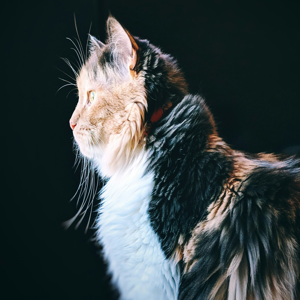

In [59]:
# Let's look at one of the training sample
print(train_instances[0])

query_image_uri = train_instances[0]["contents"][0]["parts"][0]["fileData"]["fileUri"]
blob_name = query_image_uri.replace(f"{BUCKET_URI}/", "")
img = read_image_bytes_from_gcs(BUCKET_NAME, blob_name)

# Display image bytes using pil python library
image = Image.open(io.BytesIO(img))
resized_img = image.resize((300, 300))
display(resized_img)

In [14]:
# save the training data to gcs bucket
!gsutil cp train.jsonl {BUCKET_URI}/train/

Copying file://train.jsonl [Content-Type=application/octet-stream]...
/ [1 files][ 50.4 KiB/ 50.4 KiB]                                                
Operation completed over 1 objects/50.4 KiB.                                     


#### Validation data

In [60]:
# Set the filepath to your validation data and format the validation samples
val_file_path = "data_val10.jsonl"
val_instances = create_tuning_samples(val_file_path)

# save the validation instances to jsonl file
save_jsonlines("val.jsonl", val_instances)

{'contents': [{'role': 'user', 'parts': [{'fileData': {'mimeType': 'image/jpeg', 'fileUri': 'gs://wq-gemini-image-sft/images/91.jpeg'}}, {'text': 'Describe this image in detail that captures the essence of it.'}]}, {'role': 'model', 'parts': [{'text': 'A person wearing a pink shirt and a long-sleeved shirt with a large cuff, has their hand on a concrete ledge. The hand is on the edge of the ledge, and the thumb is on the edge of the hand. The shirt has a large cuff, and the sleeve is rolled up. The shadow of the hand is on the wall.'}]}]}


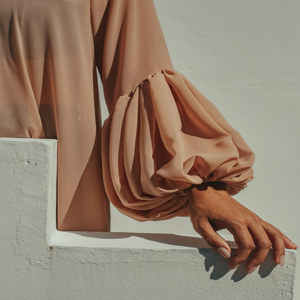

In [61]:
# Let's look at one of the validation sample
print(val_instances[0])

query_image_uri = val_instances[0]["contents"][0]["parts"][0]["fileData"]["fileUri"]
blob_name = query_image_uri.replace(f"{BUCKET_URI}/", "")
img = read_image_bytes_from_gcs(BUCKET_NAME, blob_name)

# Display image bytes using pil python library
image = Image.open(io.BytesIO(img))
resized_img = image.resize((300, 300))
display(resized_img)

In [17]:
# save the validation data to gcs bucket
!gsutil cp val.jsonl {BUCKET_URI}/val/

Copying file://val.jsonl [Content-Type=application/octet-stream]...
/ [1 files][  5.1 KiB/  5.1 KiB]                                                
Operation completed over 1 objects/5.1 KiB.                                      


#### Tranforming the JSONL format

For the validation dataset, we will need to format the data to the following structure:

`
[{'file_uri': '<GCS path for query image>',
 'ground_truth': '<Ground truth, image description'},
 ..
]
`

In [62]:
# Let's format the validation instances into the specified structure
data_table = []
for instance in val_instances:
    data_table.append(
        {
            "file_uri": instance["contents"][0]["parts"][0]["fileData"]["fileUri"],
            "ground_truth": instance["contents"][1]["parts"][0]["text"],
        }
    )

In [63]:
# Let's verify that the output is in the correct structure
data_table[0]

{'file_uri': 'gs://wq-gemini-image-sft/images/91.jpeg',
 'ground_truth': 'A person wearing a pink shirt and a long-sleeved shirt with a large cuff, has their hand on a concrete ledge. The hand is on the edge of the ledge, and the thumb is on the edge of the hand. The shirt has a large cuff, and the sleeve is rolled up. The shadow of the hand is on the wall.'}

In [67]:
# The `data_table` is converted into dataframe of two columns, file_uri and ground_truth. The `ground_truth` will be compared with the model generated output

val_df = pd.DataFrame(data_table)
val_df

,file_uri,ground_truth
0,gs://wq-gemini-image-sft/images/91.jpeg,A person wearing a pink shirt and a long-sleev...
1,gs://wq-gemini-image-sft/images/92.jpeg,A woman in a floral dress stands on a ledge. T...
2,gs://wq-gemini-image-sft/images/93.jpeg,A woman in a red jacket and black pants with a...
3,gs://wq-gemini-image-sft/images/94.jpeg,"A woman stands on a set of stone steps, holdin..."
4,gs://wq-gemini-image-sft/images/95.jpeg,"A person's hand rests on a pink sweater, adorn..."
5,gs://wq-gemini-image-sft/images/96.jpeg,"A man with long, blonde hair and a black sweat..."
6,gs://wq-gemini-image-sft/images/97.jpeg,A white rack with hangers on it. The rack is w...
7,gs://wq-gemini-image-sft/images/98.jpeg,A white garment hangs on a wooden hanger in a ...
8,gs://wq-gemini-image-sft/images/99.jpeg,"A woman stands on a sidewalk, holding a black ..."
9,gs://wq-gemini-image-sft/images/100.jpeg,"A man stands on a road, wearing a blue denim j..."


Total `10` instances in validation data

## Evaluating Gemini 1.5 Pro: Pre-Tuning

In [22]:
# Load the `gemini-1.5-pro-002` model
base_model = "gemini-1.5-pro-002"
generation_model = GenerativeModel(base_model)

### Generation config

- Each call that you send to a model includes parameter values that control how the model generates a response. The model can generate different results for different parameter values
- <strong>Experiment</strong> with different parameter values to get the best values for the task

Refer to the following [link](https://cloud.google.com/vertex-ai/generative-ai/docs/learn/prompts/adjust-parameter-values) for understanding different parameters

**Prompt** is a natural language request submitted to a language model to receive a response back

Some best practices include
  - Clearly communicate what content or information is most important
  - Structure the prompt:
    - Defining the role if using one. For example, You are an experienced UX designer at a top tech company
    - Include context and input data
    - Provide the instructions to the model
    - Add example(s) if you are using them

Refer to the following [link](https://cloud.google.com/vertex-ai/generative-ai/docs/learn/prompts/prompt-design-strategies) for prompt design strategies.

### Task

***Task prompt:***

`
"<image>, Describe this image that captures the essence of it. "
`

***Query Image (image)***


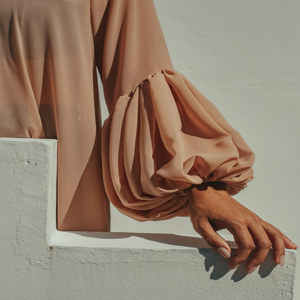

In [23]:
query_image_uri = val_instances[0]["contents"][0]["parts"][0]["fileData"]["fileUri"]
blob_name = query_image_uri.replace(f"{BUCKET_URI}/", "")
img = read_image_bytes_from_gcs(BUCKET_NAME, blob_name)

# Display image bytes using pil python library
image = Image.open(io.BytesIO(img))
resized_img = image.resize((300, 300))
display(resized_img)

### Testing on single instance
#### Gemini 1.5 Pro's response
<b>Prompt used:</b> Describe this image that captures the essence of it.

In [24]:
response = generation_model.generate_content(
    contents=[
        Part.from_uri(query_image_uri, "image/jpeg"),
        "Describe this image that captures the essence of it.",
    ],
    # Optional config
    generation_config=GenerationConfig(
        temperature=0.0,
    ),
)

print(response.text.strip())

The image presents a close-up, slightly low-angle view of a person's arm and hand resting on a white, textured surface, likely a wall or step.  The focus is on the unique sleeve of the garment and the interplay of light and shadow.

Here's a breakdown of the key elements:

* **Sleeve:** The sleeve is a light, dusty rose or peach color, made of a sheer, delicate fabric that gathers and bunches into voluminous, rounded folds around the wrist. It creates a dramatic, flowing effect. The fabric appears lightweight and slightly translucent, allowing some light to pass through.
* **Hand:** A darker-skinned hand rests gently on the white surface. The fingers are relaxed and slightly curved, and the nails appear to have a neutral or pale polish.
* **Wall/Surface:** The white surface against which the arm and hand are placed has a rough, slightly uneven texture, possibly stucco or concrete. The bright sunlight casts a distinct shadow of the hand and sleeve onto the surface.
* **Light and Shadow:

#### Ground truth

In [25]:
val_instances[0]["contents"][1]["parts"][0]["text"]

'A person wearing a pink shirt and a long-sleeved shirt with a large cuff, has their hand on a concrete ledge. The hand is on the edge of the ledge, and the thumb is on the edge of the hand. The shirt has a large cuff, and the sleeve is rolled up. The shadow of the hand is on the wall.'

#### Change prompt to get detailed description for the provided image
* <b>Old prompt used:</b> Describe this image that captures the essence of it.
* <b>New prompt used:</b> Describe this image in <b>detail</b> that captures the essence of it.

In [26]:
response = generation_model.generate_content(
    contents=[
        Part.from_uri(query_image_uri, "image/jpeg"),
        "Describe this image in detail that captures the essence of it.",
    ],
    # Optional config
    generation_config=GenerationConfig(
        temperature=0.0,
    ),
)

print(response.text.strip())

Close-up, slightly low-angle view of a person's arm and hand resting on a white surface, with the main focus on the voluminous, gathered sleeve of their garment. 


The sleeve is a light, dusty rose or peach color, made of a sheer, delicate fabric that bunches into soft folds and creates a dramatic, puffy effect.  It appears to be gathered tightly at the wrist, just above the hand, and then expands outward toward the elbow.  The fabric of the sleeve is translucent enough to allow some light to pass through, revealing subtle variations in color and texture. 


The hand resting on the white surface is medium-toned with long, slender fingers.  The nails are painted a pale, neutral color, close to the skin tone.  The hand is relaxed, with the fingers slightly curved. 


The white surface the hand rests on appears to be a wall or ledge with a textured, slightly rough surface.  The light source is strong and comes from above, casting shadows from the hand and sleeve onto the white surface.  

## Evaluation before model tuning
Evaluate the Gemini model on the validation dataset before tuning it on the training dataset.

### Utility Functions

In [27]:
def get_prediction(query_image, generation_model):
    """Gets the prediction for a given instance.

    Args:
      query_image: The path to the query image.
      candidates: A list of paths to the candidate images.
      generation_model: The generation model to use for prediction.

    Returns:
      A string containing the prediction.
    """
    response = generation_model.generate_content(
        contents=[Part.from_uri(query_image, "image/jpeg"), task_prompt],
        # Optional config
        generation_config=GenerationConfig(
            temperature=0.0,
        ),
    )

    return response.text.strip()

def run_eval(val_df, model=generation_model):
    """Runs evaluation on the validation dataset.

    Args:
      val_df: The validation dataframe.
      generation_model: The generation model to use for evaluation.

    Returns:
      A list of predictions on val_df.
    """
    predictions = []
    for i, row in tqdm(val_df.iterrows(), total=val_df.shape[0]):
        try:
            prediction = get_prediction(row["file_uri"], model)
        except:
            time.sleep(30)
            prediction = get_prediction(row["file_uri"], model)
        predictions.append(prediction)
        time.sleep(1)
    return predictions

### Evaluating pre-tuned Gemini 1.5 Pro on the validation dataset

<div class="alert alert-block alert-warning">
<b>⚠️ It will take 1-2 mins for the model to generate predictions on the provided validation dataset. ⚠️</b>
</div>

In [29]:
%%time
predictions = run_eval(val_df, model=generation_model)

100%|██████████| 10/10 [01:15<00:00,  7.58s/it]

CPU times: user 125 ms, sys: 46.6 ms, total: 171 ms
Wall time: 1min 15s


In [31]:
val_df.loc[:, "basePredictions"] = predictions

In [32]:
val_df

,file_uri,ground_truth,basePredictions
0,gs://gemini-image-sft/images/91.jpeg,A person wearing a pink shirt and a long-sleev...,"Close-up, slightly low-angle view of a person'..."
1,gs://gemini-image-sft/images/92.jpeg,A woman in a floral dress stands on a ledge. T...,"Close-up, slightly low-angle view of a woman's..."
2,gs://gemini-image-sft/images/93.jpeg,A woman in a red jacket and black pants with a...,"Close-up, slightly low-angle view of a person ..."
3,gs://gemini-image-sft/images/94.jpeg,"A woman stands on a set of stone steps, holdin...","Close-up, slightly low-angle view of a person'..."
4,gs://gemini-image-sft/images/95.jpeg,"A person's hand rests on a pink sweater, adorn...",This overhead close-up shot captures a casuall...
5,gs://gemini-image-sft/images/96.jpeg,"A man with long, blonde hair and a black sweat...","Close-up, slightly low-angle view of a person,..."
6,gs://gemini-image-sft/images/97.jpeg,A white rack with hangers on it. The rack is w...,"Close-up, slightly low-angle view of a section..."
7,gs://gemini-image-sft/images/98.jpeg,A white garment hangs on a wooden hanger in a ...,"Close-up, slightly low-angle view of clothing ..."
8,gs://gemini-image-sft/images/99.jpeg,"A woman stands on a sidewalk, holding a black ...","Close-up, slightly low-angle view of a person'..."
9,gs://gemini-image-sft/images/100.jpeg,"A man stands on a road, wearing a blue denim j...","Close-up, slightly low-angle view of a person'..."


### Evaluation metric

The type of metrics used for evaluation depends on the task that you are evaluating. The following table shows the supported tasks and the metrics used to evaluate each task:

| Task             | Metric(s)                     |
|-----------------|---------------------------------|
| Classification   | Micro-F1, Macro-F1, Per class F1 |
| Summarization    | ROUGE-L                         |
| Question Answering | Exact Match                     |
| Text Generation  | BLEU, ROUGE-L                   |


For this task, we'll using ROUGE metric.

- **Recall-Oriented Understudy for Gisting Evaluation (ROUGE)**: A metric used to evaluate the quality of automatic summaries of text. It works by comparing a generated summary to a set of reference summaries created by humans.

Now you can take the candidate and reference to evaluate the performance. In this case, ROUGE will give you:

- `rouge-1`, which measures unigram overlap
- `rouge-2`, which measures bigram overlap
- `rouge-l`, which measures the longest common subsequence

- *Recall vs. Precision*

    **Recall**, meaning it prioritizes how much of the information in the reference summaries is captured in the generated summary.

    **Precision**, which measures how much of the generated summary is relevant to the original text.

- Initialize `rouge_score` object

In [33]:
scorer = rouge_scorer.RougeScorer(["rouge1", "rouge2", "rougeL"], use_stemmer=True)

- Define function to calculate rouge score

In [34]:
def get_rouge_score(groundTruth, prediction):
    """Function to compute rouge score.

    Args:
      groundTruth: The ground truth text.
      prediction: The predicted text.
    Returns:
      The rouge score.
    """
    scores = scorer.score(target=groundTruth, prediction=prediction)
    return scores

- Single instance evaluation

In [35]:
get_rouge_score(val_df.loc[0, "ground_truth"], val_df.loc[0, "basePredictions"])

{'rouge1': Score(precision=0.2393617021276596, recall=0.7258064516129032, fmeasure=0.36000000000000004),
 'rouge2': Score(precision=0.06951871657754011, recall=0.21311475409836064, fmeasure=0.10483870967741936),
 'rougeL': Score(precision=0.15425531914893617, recall=0.46774193548387094, fmeasure=0.232)}

In [36]:
def calculate_metrics(val_df, prediction_col="basePredictions"):
    """Function to compute rouge scores for all instances in the validation dataset.
    Args:
      val_df: The validation dataframe.
      prediction_col: The column name of the predictions.
    Returns:
      A dataframe containing the rouge scores.
    """
    records = []
    for row, instance in val_df.iterrows():
        scores = get_rouge_score(instance["ground_truth"], instance[prediction_col])
        records.append(
            {
                "rouge1_precision": scores.get("rouge1").precision,
                "rouge1_recall": scores.get("rouge1").recall,
                "rouge1_fmeasure": scores.get("rouge1").fmeasure,
                "rouge2_precision": scores.get("rouge2").precision,
                "rouge2_recall": scores.get("rouge2").recall,
                "rouge2_fmeasure": scores.get("rouge2").fmeasure,
                "rougeL_precision": scores.get("rougeL").precision,
                "rougeL_recall": scores.get("rougeL").recall,
                "rougeL_fmeasure": scores.get("rougeL").fmeasure,
            }
        )
    metrics = pd.DataFrame(records)
    return metrics

In [37]:
evaluation_df_stats = calculate_metrics(val_df, prediction_col="basePredictions")
evaluation_df_stats

,rouge1_precision,rouge1_recall,rouge1_fmeasure,rouge2_precision,rouge2_recall,rouge2_fmeasure,rougeL_precision,rougeL_recall,rougeL_fmeasure
0,0.239362,0.725806,0.360000,0.069519,0.213115,0.104839,0.154255,0.467742,0.232000
1,0.333333,0.771930,0.465608,0.122137,0.285714,0.171123,0.174242,0.403509,0.243386
2,0.095694,0.714286,0.168776,0.033654,0.259259,0.059574,0.076555,0.571429,0.135021
3,0.240838,0.730159,0.362205,0.063158,0.193548,0.095238,0.146597,0.444444,0.220472
4,0.133333,0.666667,0.222222,0.015464,0.078947,0.025862,0.097436,0.487179,0.162393
5,0.156069,0.658537,0.252336,0.011628,0.050000,0.018868,0.104046,0.439024,0.168224
6,0.164835,0.810811,0.273973,0.055249,0.277778,0.092166,0.120879,0.594595,0.200913
7,0.316770,0.680000,0.432203,0.106250,0.229730,0.145299,0.186335,0.400000,0.254237
8,0.276596,0.666667,0.390977,0.069519,0.168831,0.098485,0.154255,0.371795,0.218045
9,0.201754,0.666667,0.309764,0.044053,0.147059,0.067797,0.114035,0.376812,0.175084


In [38]:
print("Mean rougeL_precision is", evaluation_df_stats.rougeL_precision.mean())
print("Mean rougeL_recall is", evaluation_df_stats.rougeL_recall.mean())
print("Mean rougeL_fmeasure is", evaluation_df_stats.rougeL_fmeasure.mean())

Mean rougeL_precision is 0.1328636697638076
Mean rougeL_recall is 0.4556528661302465
Mean rougeL_fmeasure is 0.20097770608469773


## Fine-tune the model

When you run a supervised fine-tuning job, the model learns additional parameters that help it encode the necessary information to perform the desired task or learn the desired behavior. These parameters are used during inference. The output of the tuning job is a new model that combines the newly learned parameters with the original model.

**Tuning Job parameters**

- `source_model`: Specifies the base Gemini model version you want to fine-tune.
- `train_dataset`: Path to your training data in JSONL format.


 *Optional parameters*
 - `validation_dataset`: If provided, this data is used to evaluate the model during tuning.
 - `tuned_model_display_name`: Display name for the tuned model.
 
 *Hyperparameters* 
 - `epochs`: The number of training epochs to run.
 - `learning_rate_multiplier`: A value to scale the learning rate during training.
 - `adapter_size` : Gemini 1.5 Pro supports Adapter length [1, 4], default value is 4.


**Note: The default hyperparameter settings are optimized for optimal performance based on rigorous testing and are recommended for initial use. Users may customize these parameters to address specific performance requirements.**

In [39]:
tuned_model_display_name = PREFIX + "-gemini-1.5-pro-image-tuned"  # @param {type:"string"}

sft_tuning_job = sft.train(
    source_model=base_model,
    train_dataset=f"{BUCKET_URI}/train/train.jsonl",
    # Optional:
    validation_dataset=f"{BUCKET_URI}/val/val.jsonl",
    tuned_model_display_name=tuned_model_display_name,
)

Creating SupervisedTuningJob


INFO:vertexai.tuning._tuning:Creating SupervisedTuningJob


SupervisedTuningJob created. Resource name: projects/951134149941/locations/us-central1/tuningJobs/9113966609801674752


INFO:vertexai.tuning._tuning:SupervisedTuningJob created. Resource name: projects/951134149941/locations/us-central1/tuningJobs/9113966609801674752


To use this SupervisedTuningJob in another session:


INFO:vertexai.tuning._tuning:To use this SupervisedTuningJob in another session:


tuning_job = sft.SupervisedTuningJob('projects/951134149941/locations/us-central1/tuningJobs/9113966609801674752')


INFO:vertexai.tuning._tuning:tuning_job = sft.SupervisedTuningJob('projects/951134149941/locations/us-central1/tuningJobs/9113966609801674752')


View Tuning Job:
https://console.cloud.google.com/vertex-ai/generative/language/locations/us-central1/tuning/tuningJob/9113966609801674752?project=951134149941


INFO:vertexai.tuning._tuning:View Tuning Job:
https://console.cloud.google.com/vertex-ai/generative/language/locations/us-central1/tuning/tuningJob/9113966609801674752?project=951134149941


In [40]:
job_name = sft_tuning_job.to_dict()["name"]
job_name

'projects/951134149941/locations/us-central1/tuningJobs/9113966609801674752'

In [41]:
sft_tuning_job.to_dict()

{'name': 'projects/951134149941/locations/us-central1/tuningJobs/9113966609801674752',
 'tunedModelDisplayName': 'gemini-1.5-pro-image-tuned',
 'baseModel': 'gemini-1.5-pro-002',
 'supervisedTuningSpec': {'trainingDatasetUri': 'gs://gemini-image-sft/train/train.jsonl',
  'validationDatasetUri': 'gs://gemini-image-sft/val/val.jsonl',
  'hyperParameters': {}},
 'state': 'JOB_STATE_PENDING',
 'createTime': '2024-10-22T15:39:26.868246Z',
 'updateTime': '2024-10-22T15:39:26.868246Z'}

**Note: Tuning time depends on several factors, such as training data size, number of epochs, learning rate multiplier, etc.**

<div class="alert alert-block alert-warning">
<b>⚠️ It will take ~60mins for the model tuning job to complete on the provided dataset and set configurations/hyperparameters. ⚠️</b>
</div>

In [42]:
%%time
# Wait for job completion
while not sft_tuning_job.refresh().has_ended:
    time.sleep(60)

CPU times: user 5.39 s, sys: 1.82 s, total: 7.22 s
Wall time: 1h 2min 13s


In [43]:
sft_tuning_job.to_dict()

{'name': 'projects/951134149941/locations/us-central1/tuningJobs/9113966609801674752',
 'tunedModelDisplayName': 'gemini-1.5-pro-image-tuned',
 'baseModel': 'gemini-1.5-pro-002',
 'supervisedTuningSpec': {'trainingDatasetUri': 'gs://gemini-image-sft/train/train.jsonl',
  'validationDatasetUri': 'gs://gemini-image-sft/val/val.jsonl',
  'hyperParameters': {'epochCount': '10',
   'learningRateMultiplier': 1.0,
   'adapterSize': 'ADAPTER_SIZE_FOUR'}},
 'state': 'JOB_STATE_SUCCEEDED',
 'createTime': '2024-10-22T15:39:26.868246Z',
 'startTime': '2024-10-22T15:39:35.617094Z',
 'endTime': '2024-10-22T16:42:43.589584Z',
 'updateTime': '2024-10-22T16:42:43.589584Z',
 'experiment': 'projects/951134149941/locations/us-central1/metadataStores/default/contexts/tuning-experiment-20241022084054385593',
 'tunedModel': {'model': 'projects/951134149941/locations/us-central1/models/6725920434803441664@1',
  'endpoint': 'projects/951134149941/locations/us-central1/endpoints/2719137335466786816'},
 'tuningD

## Evaluation Post-tuning

- Evaluate the Gemini model on the validation dataset with tuned model.

In [44]:
tuning_job = sft.SupervisedTuningJob(job_name)

# tuned model endpoint name
tuned_model_endpoint_name = tuning_job.tuned_model_endpoint_name

tuned_model = GenerativeModel(tuned_model_endpoint_name)

In [45]:
# Get experiment resource name from tuning job.
experiment_name = tuning_job.experiment.resource_name
experiment_name

'projects/951134149941/locations/us-central1/metadataStores/default/contexts/tuning-experiment-20241022084054385593'

In [46]:
# tuned model name
tuned_model_name = tuning_job.tuned_model_name
tuned_model_name

'projects/951134149941/locations/us-central1/models/6725920434803441664@1'

- Get a prediction from base model

In [47]:
response = generation_model.generate_content(
    contents=[Part.from_uri(query_image_uri, "image/jpeg"), task_prompt],
    # Optional config
    generation_config=GenerationConfig(
        temperature=0.0,
    ),
)

print(response.text.strip())

Close-up, slightly low-angle view of a person's arm and hand resting on a white, textured surface, likely a wall or ledge. 


The focus is on the sleeve and hand. The sleeve is a light, dusty rose or peach color, made of a sheer, gauzy fabric. It's a long, loose-fitting sleeve that gathers and bunches at the wrist, creating a voluminous, "balloon" or "bishop" style cuff. The fabric of the sleeve appears delicate and flows softly. 


The hand resting on the white surface is a darker skin tone. The fingers are relaxed and slightly curved, with short, neutral-toned nails. 


The white surface against which the hand and sleeve are positioned has a rough, stucco-like texture. The bright sunlight casts shadows from the sleeve and hand onto the surface, adding depth and contrast to the image.  The background is a similar light-colored surface, likely a continuation of the wall, and is slightly out of focus, drawing attention to the foreground elements. The overall impression is one of soft, e

- Get a prediction from tuned model

In [48]:
response = tuned_model.generate_content(
    contents=[Part.from_uri(query_image_uri, "image/jpeg"), task_prompt],
    # Optional config
    generation_config=GenerationConfig(
        temperature=0.0,
    ),
)

print(response.text.strip())

A woman stands in front of a white wall, her hand resting on the wall. The woman is wearing a long-sleeved shirt with a long sleeve and a long skirt. The shirt is brown and the skirt is brown. The woman's hand is on the wall, and her fingers are spread out. The wall is white and the woman's shadow is on the wall. The woman's nails are painted pink.


- Evaluate the tuned model on entire validation set

<div class="alert alert-block alert-warning">
<b>⚠️ It will take 1-2 mins for the model to generate predictions on the provided validation dataset. ⚠️</b>
</div>

In [49]:
%%time
predictions_tuned = run_eval(val_df, model=tuned_model)

100%|██████████| 10/10 [01:03<00:00,  6.39s/it]

CPU times: user 153 ms, sys: 28.4 ms, total: 181 ms
Wall time: 1min 3s


In [50]:
val_df.loc[:, "tunedPredictions"] = predictions_tuned

In [51]:
evaluation_df_post_tuning_stats = calculate_metrics(
    val_df, prediction_col="tunedPredictions"
)
evaluation_df_post_tuning_stats

,rouge1_precision,rouge1_recall,rouge1_fmeasure,rouge2_precision,rouge2_recall,rouge2_fmeasure,rougeL_precision,rougeL_recall,rougeL_fmeasure
0,0.426230,0.419355,0.422764,0.133333,0.131148,0.132231,0.311475,0.306452,0.308943
1,0.587302,0.649123,0.616667,0.338710,0.375000,0.355932,0.396825,0.438596,0.416667
2,0.193548,0.642857,0.297521,0.108696,0.370370,0.168067,0.172043,0.571429,0.264463
3,0.507692,0.523810,0.515625,0.203125,0.209677,0.206349,0.384615,0.396825,0.390625
4,0.403226,0.641026,0.495050,0.114754,0.184211,0.141414,0.258065,0.410256,0.316832
5,0.557692,0.707317,0.623656,0.333333,0.425000,0.373626,0.403846,0.512195,0.451613
6,0.577778,0.702703,0.634146,0.340909,0.416667,0.375000,0.466667,0.567568,0.512195
7,0.611940,0.546667,0.577465,0.348485,0.310811,0.328571,0.492537,0.440000,0.464789
8,0.803279,0.628205,0.705036,0.483333,0.376623,0.423358,0.491803,0.384615,0.431655
9,0.398230,0.652174,0.494505,0.223214,0.367647,0.277778,0.327434,0.536232,0.406593


- Improvement

In [52]:
evaluation_df_post_tuning_stats.rougeL_precision.mean()

0.37053107591113327

In [53]:
improvement = round(
    (
        (
            evaluation_df_post_tuning_stats.rougeL_precision.mean()
            - evaluation_df_stats.rougeL_precision.mean()
        )
        / evaluation_df_stats.rougeL_precision.mean()
    )
    * 100,
    2,
)
print(
    f"Model tuning has improved the rougeL_precision by {improvement}% (result might differ based on each tuning iteration)"
)

Model tuning has improved the rougeL_precision by 178.88% (result might differ based on each tuning iteration)


In [54]:
# Save predicitons
predictions_all = val_df.to_csv("validation_pred.csv", index=False)

## Conclusion

Performance could be further improved:
- By adding more training samples. In general, improve your training data quality and/or quantity towards getting a more diverse and comprehensive dataset for your task
- By tuning the hyperparameters, such as epochs, learning rate multiplier or adapter size
  - To find the optimal number of epochs for your dataset, we recommend experimenting with different values. While increasing epochs can lead to better performance, it's important to be mindful of overfitting, especially with smaller datasets. If you see signs of overfitting, reducing the number of epochs can help mitigate the issue
- You may try different prompt structures/formats and opt for the one with better performance

## Cleaning up

To clean up all Google Cloud resources used in this project, you can [delete the Google Cloud
project](https://cloud.google.com/resource-manager/docs/creating-managing-projects#shutting_down_projects) you used for the tutorial.


Otherwise, you can delete the individual resources you created in this tutorial.

Refer to this [instructions](https://cloud.google.com/vertex-ai/docs/tutorials/image-classification-custom/cleanup#delete_resources) to delete the resources from console.

In [55]:
# Delete Experiment.
delete_experiments = True
if delete_experiments:
    experiments_list = aiplatform.Experiment.list()
    for experiment in experiments_list:
        if experiment.resource_name == experiment_name:
            print(experiment.resource_name)
            experiment.delete()
            break

print("***" * 10)

# Delete Endpoint.
delete_endpoint = True
# If force is set to True, all deployed models on this
# Endpoint will be first undeployed.
if delete_endpoint:
    for endpoint in aiplatform.Endpoint.list():
        if endpoint.resource_name == tuned_model_endpoint_name:
            print(endpoint.resource_name)
            endpoint.delete(force=True)
            break

print("***" * 10)

# Delete Cloud Storage Bucket.
delete_bucket = True
if delete_bucket:
    ! gsutil -m rm -r $BUCKET_URI

projects/951134149941/locations/us-central1/metadataStores/default/contexts/tuning-experiment-20241022084054385593
Experiment run tuning-experiment-run-20241022084054385593 skipped backing tensorboard run deletion.
To delete backing tensorboard run, execute the following:
tensorboard_run_artifact = aiplatform.metadata.artifact.Artifact(artifact_name=f"tuning-experiment-20241022084054385593-tuning-experiment-run-20241022084054385593-tb-run")
tensorboard_run_resource = aiplatform.TensorboardRun(tensorboard_run_artifact.metadata["resourceName"])
tensorboard_run_resource.delete()
tensorboard_run_artifact.delete()


To delete backing tensorboard run, execute the following:
tensorboard_run_artifact = aiplatform.metadata.artifact.Artifact(artifact_name=f"tuning-experiment-20241022084054385593-tuning-experiment-run-20241022084054385593-tb-run")
tensorboard_run_resource = aiplatform.TensorboardRun(tensorboard_run_artifact.metadata["resourceName"])
tensorboard_run_resource.delete()
tensorboard_run_artifact.delete()


Deleting Context : projects/951134149941/locations/us-central1/metadataStores/default/contexts/tuning-experiment-20241022084054385593-tuning-experiment-run-20241022084054385593


INFO:google.cloud.aiplatform.base:Deleting Context : projects/951134149941/locations/us-central1/metadataStores/default/contexts/tuning-experiment-20241022084054385593-tuning-experiment-run-20241022084054385593


Context deleted. . Resource name: projects/951134149941/locations/us-central1/metadataStores/default/contexts/tuning-experiment-20241022084054385593-tuning-experiment-run-20241022084054385593


INFO:google.cloud.aiplatform.base:Context deleted. . Resource name: projects/951134149941/locations/us-central1/metadataStores/default/contexts/tuning-experiment-20241022084054385593-tuning-experiment-run-20241022084054385593


Deleting Context resource: projects/951134149941/locations/us-central1/metadataStores/default/contexts/tuning-experiment-20241022084054385593-tuning-experiment-run-20241022084054385593


INFO:google.cloud.aiplatform.base:Deleting Context resource: projects/951134149941/locations/us-central1/metadataStores/default/contexts/tuning-experiment-20241022084054385593-tuning-experiment-run-20241022084054385593


Delete Context backing LRO: projects/951134149941/locations/us-central1/metadataStores/default/contexts/tuning-experiment-20241022084054385593-tuning-experiment-run-20241022084054385593/operations/8182247397091442688


INFO:google.cloud.aiplatform.base:Delete Context backing LRO: projects/951134149941/locations/us-central1/metadataStores/default/contexts/tuning-experiment-20241022084054385593-tuning-experiment-run-20241022084054385593/operations/8182247397091442688


Context resource projects/951134149941/locations/us-central1/metadataStores/default/contexts/tuning-experiment-20241022084054385593-tuning-experiment-run-20241022084054385593 deleted.


INFO:google.cloud.aiplatform.base:Context resource projects/951134149941/locations/us-central1/metadataStores/default/contexts/tuning-experiment-20241022084054385593-tuning-experiment-run-20241022084054385593 deleted.


Deleting Context : projects/951134149941/locations/us-central1/metadataStores/default/contexts/tuning-experiment-20241022084054385593


INFO:google.cloud.aiplatform.base:Deleting Context : projects/951134149941/locations/us-central1/metadataStores/default/contexts/tuning-experiment-20241022084054385593


Context deleted. . Resource name: projects/951134149941/locations/us-central1/metadataStores/default/contexts/tuning-experiment-20241022084054385593


INFO:google.cloud.aiplatform.base:Context deleted. . Resource name: projects/951134149941/locations/us-central1/metadataStores/default/contexts/tuning-experiment-20241022084054385593


Deleting Context resource: projects/951134149941/locations/us-central1/metadataStores/default/contexts/tuning-experiment-20241022084054385593


INFO:google.cloud.aiplatform.base:Deleting Context resource: projects/951134149941/locations/us-central1/metadataStores/default/contexts/tuning-experiment-20241022084054385593


Delete Context backing LRO: projects/951134149941/locations/us-central1/metadataStores/default/contexts/tuning-experiment-20241022084054385593/operations/223260955620933632


INFO:google.cloud.aiplatform.base:Delete Context backing LRO: projects/951134149941/locations/us-central1/metadataStores/default/contexts/tuning-experiment-20241022084054385593/operations/223260955620933632


Context resource projects/951134149941/locations/us-central1/metadataStores/default/contexts/tuning-experiment-20241022084054385593 deleted.


INFO:google.cloud.aiplatform.base:Context resource projects/951134149941/locations/us-central1/metadataStores/default/contexts/tuning-experiment-20241022084054385593 deleted.


******************************
projects/951134149941/locations/us-central1/endpoints/2719137335466786816
Undeploying Endpoint model: projects/951134149941/locations/us-central1/endpoints/2719137335466786816


INFO:google.cloud.aiplatform.models:Undeploying Endpoint model: projects/951134149941/locations/us-central1/endpoints/2719137335466786816


Undeploy Endpoint model backing LRO: projects/951134149941/locations/us-central1/endpoints/2719137335466786816/operations/6272721155086352384


INFO:google.cloud.aiplatform.models:Undeploy Endpoint model backing LRO: projects/951134149941/locations/us-central1/endpoints/2719137335466786816/operations/6272721155086352384


Endpoint model undeployed. Resource name: projects/951134149941/locations/us-central1/endpoints/2719137335466786816


INFO:google.cloud.aiplatform.models:Endpoint model undeployed. Resource name: projects/951134149941/locations/us-central1/endpoints/2719137335466786816


Deleting Endpoint : projects/951134149941/locations/us-central1/endpoints/2719137335466786816


INFO:google.cloud.aiplatform.base:Deleting Endpoint : projects/951134149941/locations/us-central1/endpoints/2719137335466786816


Endpoint deleted. . Resource name: projects/951134149941/locations/us-central1/endpoints/2719137335466786816


INFO:google.cloud.aiplatform.base:Endpoint deleted. . Resource name: projects/951134149941/locations/us-central1/endpoints/2719137335466786816


Deleting Endpoint resource: projects/951134149941/locations/us-central1/endpoints/2719137335466786816


INFO:google.cloud.aiplatform.base:Deleting Endpoint resource: projects/951134149941/locations/us-central1/endpoints/2719137335466786816


Delete Endpoint backing LRO: projects/951134149941/locations/us-central1/operations/2886295710280450048


INFO:google.cloud.aiplatform.base:Delete Endpoint backing LRO: projects/951134149941/locations/us-central1/operations/2886295710280450048


Endpoint resource projects/951134149941/locations/us-central1/endpoints/2719137335466786816 deleted.


INFO:google.cloud.aiplatform.base:Endpoint resource projects/951134149941/locations/us-central1/endpoints/2719137335466786816 deleted.


******************************
Removing gs://gemini-image-sft/images/20.jpeg#1729611251283975...
Removing gs://gemini-image-sft/images/1.jpeg#1729611251046026...
Removing gs://gemini-image-sft/images/18.jpeg#1729611251140833...
Removing gs://gemini-image-sft/images/10.jpeg#1729611251004270...
Removing gs://gemini-image-sft/images/100.jpeg#1729611251086653...
Removing gs://gemini-image-sft/images/23.jpeg#1729611251245491...
Removing gs://gemini-image-sft/images/24.jpeg#1729611251211907...
Removing gs://gemini-image-sft/images/11.jpeg#1729611251412029...
Removing gs://gemini-image-sft/images/19.jpeg#1729611251370626...
Removing gs://gemini-image-sft/images/13.jpeg#1729611251024016...
Removing gs://gemini-image-sft/images/12.jpeg#1729611251280857...
Removing gs://gemini-image-sft/images/14.jpeg#1729611251123563...
Removing gs://gemini-image-sft/images/15.jpeg#1729611251313422...
Removing gs://gemini-image-sft/images/25.jpeg#1729611251177523...
Removing gs://gemini-image-sft/images/21.jpeg